# Imports

In [1]:
import os
import shutil
import random
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Visualizing total images


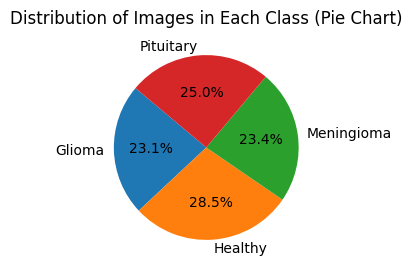

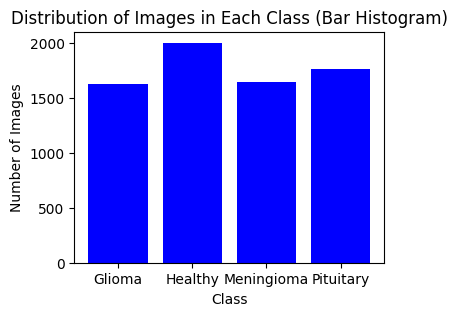

In [2]:
folder_path = './dataset_raw'

class_counts = {}

for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)
    
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        
        class_counts[class_folder] = num_images

plt.figure(figsize=(4, 3))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images in Each Class (Pie Chart)')
plt.show()

plt.figure(figsize=(4, 3))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class (Bar Histogram)')
plt.show()

# Training, Testing and Validation Split

In [3]:
raw_dataset = r"./dataset_raw"
new_dataset = r"./Brain_Tumor_Dataset"

if not os.path.exists(new_dataset):
    os.mkdir(new_dataset)
    os.mkdir(os.path.join(new_dataset, "Training"))
    os.mkdir(os.path.join(new_dataset, "Testing"))
    os.mkdir(os.path.join(new_dataset, "Validation"))
        
    result_list1 = []
    result_list2 = []
    result_list3 = []
    
    for splits in os.listdir(new_dataset):
        split_path = os.path.join(new_dataset, splits)
        
        for raw_cls in os.listdir(raw_dataset):
            os.mkdir(os.path.join(split_path, raw_cls))
            img_list = []
            
            for images in os.listdir(os.path.join(raw_dataset, raw_cls)):
                img_list.append(images)
                img_list = random.sample(img_list, len(img_list))
            
            result_list1.append(img_list[0:1120])
            result_list2.append(img_list[1120:1360])
            result_list3.append(img_list[1360:1600])
            
        counter = 0 
        if splits == "Training":
            for new_cls in os.listdir(split_path):
                nc_path = os.path.join(split_path, new_cls)
                nc_list = result_list1[counter]
                counter += 1
                for i in nc_list:
                    ni_path = os.path.join(nc_path, i)
                    ri_path = os.path.join(raw_dataset, new_cls, i)
                    shutil.copy2(ri_path, ni_path)
                    
        elif splits == "Testing":
            for new_cls in os.listdir(split_path):
                nc_path = os.path.join(split_path, new_cls)
                nc_list = result_list2[counter]
                counter += 1
                for i in nc_list:
                    ni_path = os.path.join(nc_path, i)
                    ri_path = os.path.join(raw_dataset, new_cls, i)
                    shutil.copy2(ri_path, ni_path)

        elif splits == "Validation":
            for new_cls in os.listdir(split_path):
                nc_path = os.path.join(split_path, new_cls)
                nc_list = result_list3[counter]
                counter += 1
                for i in nc_list:
                    ni_path = os.path.join(nc_path, i)
                    ri_path = os.path.join(raw_dataset, new_cls, i)
                    shutil.copy2(ri_path, ni_path)


    print("Folder has been created successfully")

else:
    print("Folder already exists")
    

Folder already exists


# Resizing non-uniform image resolution

In [4]:

def resize_image(input_path, output_path, new_size):
    
    img = io.imread(input_path)
    img = img.astype(np.uint8)
    resized_img = transform.resize(img, new_size)
    resized_img = (resized_img * 255).astype(np.uint8)
    io.imsave(output_path, resized_img)
    print("Image resized")
   
train_fol_path = r"./Brain_Tumor_Dataset\Training"
val_fol_path = r"./Brain_Tumor_Dataset\Validation"
test_fol_path = r"./Brain_Tumor_Dataset\Testing"

def resize_fol (path_to_fol):
    for classes in os.listdir(path_to_fol):
        rcimg_path = os.path.join(path_to_fol, classes)
        for images in os.listdir(rcimg_path):
            img_path = os.path.join(rcimg_path, images)
            resize_image(img_path, img_path, (256,256))
        print("Folder", classes, "is resized")


"""resize_fol(train_fol_path)
resize_fol(val_fol_path)
resize_fol(test_fol_path)"""

'resize_fol(train_fol_path)\nresize_fol(val_fol_path)\nresize_fol(test_fol_path)'

# Image preprocessing

In [5]:
def Image_Preprocessing_Train(path):
    image_data = ImageDataGenerator(brightness_range = (0.5, 1.5),  
                                    rescale = 1/255, 
                                    horizontal_flip = True)
    
    image = image_data.flow_from_directory(directory = path, 
                                           target_size = (256,256),
                                           batch_size = 32, 
                                           class_mode = "categorical")
    return image



def Image_Preprocessing_Test_Val(path):
    image_data = ImageDataGenerator(rescale = 1/255)
    
    image = image_data.flow_from_directory(directory = path, 
                                           target_size = (256,256),
                                           batch_size = 32, 
                                           class_mode = "categorical")
    return image


train_data = Image_Preprocessing_Train("./Brain_Tumor_Dataset\Training")
test_data = Image_Preprocessing_Test_Val("./Brain_Tumor_Dataset\Testing")
val_data = Image_Preprocessing_Test_Val("./Brain_Tumor_Dataset\Validation")


Found 4479 images belonging to 4 classes.
Found 958 images belonging to 4 classes.
Found 960 images belonging to 4 classes.


# Model architecture

In [13]:
model = Sequential()

with tf.device('/GPU:0'):
    model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu", input_shape = (256, 256, 3)))

    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Flatten())

    model.add(Dense(units = 64, activation = "relu"))

    model.add(Dense(units = 128, activation = "relu"))

    model.add(Dense(units = 4, activation = "softmax"))

print(model.summary())

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)      

# Early stopping and Model checkpoint mechanism

In [14]:
es = EarlyStopping(monitor="val_accuracy", min_delta= 0.01, patience= 6, verbose= 1, mode = 'auto')

mc = ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5", verbose= 1 , save_best_only= True , mode = 'auto')

cd = [es,mc]

# Model training

In [15]:
model.fit(train_data, epochs = 15, steps_per_epoch = 150, validation_data = val_data, callbacks = cd)

Epoch 1/15
140/150 [===========================>..] - ETA: 1s - loss: 0.7670 - accuracy: 0.6752WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2250 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_accuracy improved from -inf to 0.80937, saving model to .\bestmodel.h5
150/150 [==============================] - 26s 167ms/step - loss: 0.7670 - accuracy: 0.6752 - val_loss: 0.5047 - val_accuracy: 0.8094


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

model = tf.keras.models.load_model('./Model@95.1945066.h5')

img_path = r"C:\Users\pavan\Downloads\t1.jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

img_array /= 255.0

predictions = model.predict(img_array)

print(predictions)

predicted_class = np.argmax(predictions)
if predicted_class == 1:
    print("Healthy")
else:
    print("Not healthy")



1/1 [==============================] - 0s 66ms/step
[[4.1849106e-20 9.9999988e-01 8.0033509e-08 1.3756651e-26]]
Healthy
